In [ ]:
from google.colab import output
output.enable_custom_widget_manager()


In [ ]:
from huggingface_hub import login
login()


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

models = {
    "DeepSeek": "deepseek-ai/deepseek-coder-1.3b-instruct",
    "Phi-2": "microsoft/phi-2",
    "Gemma": "google/gemma-2b-it"
}

tokenizers = {}
model_objects = {}

for name, model_id in models.items():
    print(f"🔹 Loading {name} ...")
    tokenizers[name] = AutoTokenizer.from_pretrained(model_id)
    model_objects[name] = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
print("✅ All models loaded successfully!")


🔹 Loading DeepSeek ...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

🔹 Loading Phi-2 ...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

🔹 Loading Gemma ...


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

✅ All models loaded successfully!


In [ ]:
prompt = "Write a Python function to reverse a string."
model_name = "DeepSeek"

inputs = tokenizers[model_name](prompt, return_tensors="pt").to(device)
outputs = model_objects[model_name].generate(**inputs, max_new_tokens=100)

print(tokenizers[model_name].decode(outputs[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.


Write a Python function to reverse a string.


def reverse_string(s):
    return s[::-1]

print(reverse_string("Hello, World!"))

# Output: "!dlroW ,olleH"

# This function uses Python's slicing feature to reverse the string. The [::-1] slice means start at the end of the string and end at position 0, move with the step -1 (which means one step backwards).


In [ ]:
# ==============================
# 🔹 STEP 2 (Final Fixed Version)
# ==============================

import re, unicodedata, string, pandas as pd
from radon.complexity import cc_visit
from radon.metrics import mi_visit, mi_rank
from radon.raw import analyze

# ----------- 1️⃣  CLEAN CODE OUTPUT -----------
def clean_code_output(raw_text):
    """Extract and sanitize Python code from model output."""
    # Extract code from markdown if present
    code_blocks = re.findall(r"```(?:python)?(.*?)```", raw_text, re.DOTALL)
    code = code_blocks[0] if code_blocks else raw_text

    # Normalize and strip non-printable / invisible chars
    code = unicodedata.normalize("NFKC", code)
    code = "".join(ch for ch in code if ch in string.printable)
    code = re.sub(r'[^\x00-\x7F]+', ' ', code)  # ASCII only

    # Remove explanations before real code
    match = re.search(r"(def |import |class )", code)
    if match:
        code = code[match.start():]

    # Fix incomplete parentheses/brackets if truncated
    open_paren = code.count("(")
    close_paren = code.count(")")
    if open_paren > close_paren:
        code += ")" * (open_paren - close_paren)

    open_brack = code.count("[")
    close_brack = code.count("]")
    if open_brack > close_brack:
        code += "]" * (open_brack - close_brack)

    open_brace = code.count("{")
    close_brace = code.count("}")
    if open_brace > close_brace:
        code += "}" * (open_brace - close_brace)

    # Collapse extra newlines and trim
    code = re.sub(r"\n{3,}", "\n\n", code)
    return code.strip()

# ----------- 2️⃣  EVALUATE CODE -----------
def evaluate_code(code):
    """Safely evaluate code metrics using radon."""
    try:
        compile(code, "<string>", "exec")  # syntax validation
    except Exception as e:
        return {"error": f"Invalid code: {e}"}

    try:
        complexity_data = cc_visit(code)
        avg_complexity = (
            sum(block.complexity for block in complexity_data) / len(complexity_data)
            if complexity_data else 0
        )
        maintainability_index = mi_visit(code, True)
        mi_grade = mi_rank(maintainability_index)
        raw_metrics = analyze(code)
        loc = raw_metrics.loc

        return {
            "avg_complexity": round(avg_complexity, 2),
            "maintainability_index": round(maintainability_index, 2),
            "mi_grade": mi_grade,
            "loc": loc
        }
    except Exception as e:
        return {"error": str(e)}

# ----------- 3️⃣  GENERATE CODE FUNCTION -----------
def generate_code(model_name, prompt, max_tokens=400):
    tokenizer = tokenizers[model_name]
    model = model_objects[model_name]
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=max_tokens)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# ----------- 4️⃣  RUN ALL THREE MODELS -----------
prompt = "Write a complete Python function to check if a number is prime or not, including test cases."

results = {}
for model_name in models.keys():
    print(f"\n🚀 Generating code using {model_name} ...")
    raw_code = generate_code(model_name, prompt, max_tokens=400)
    clean_code = clean_code_output(raw_code)

    print(f"\n--- {model_name} Generated Code ---\n")
    print(clean_code[:400], "...\n")

    metrics = evaluate_code(clean_code)
    results[model_name] = {"code": clean_code, "metrics": metrics}

print("\n✅ Code generation and evaluation completed successfully!")

# ----------- 5️⃣  DISPLAY RESULTS IN TABLE -----------
df = pd.DataFrame({
    m: res["metrics"] for m, res in results.items()
}).T

display(df)


Setting `pad_token_id` to `eos_token_id`:32021 for open-end generation.



🚀 Generating code using DeepSeek ...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- DeepSeek Generated Code ---

def is_prime(n):
    if n <= 1:
        return False
    elif n <= 3:
        return True
    elif n % 2 == 0 or n % 3 == 0:
        return False
    i = 5
    while i * i <= n:
        if n % i == 0 or n % (i + 2) == 0:
            return False
        i += 6
    return True

# Test cases
print(is_prime(2))  # True
print(is_prime(4))  # False
print(is_prime(9))  # False
print(is_prime(13))  # Tru ...


🚀 Generating code using Phi-2 ...

--- Phi-2 Generated Code ---

def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, n):
        if n % i == 0:
            return False
    return True

print(is_prime(2))  # True
print(is_prime(4))  # False
print(is_prime(17))  # True ...


🚀 Generating code using Gemma ...

--- Gemma Generated Code ---

def is_prime(n):
  """
  Checks if a number is prime or not.

  Args:
    n: The number to check.

  Returns:
    True if n is prime, False otherwise.
  """

  # If n is less than 2, it is not a p

,avg_complexity,maintainability_index,mi_grade,loc
DeepSeek,8.0,79.99,A,30
Phi-2,4.0,94.13,A,11
Gemma,4.0,81.32,A,30


In [ ]:
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output


In [ ]:
# Textbox for user prompt
prompt_input = widgets.Textarea(
    value="Write a Python function to find factorial of a number.",
    placeholder="Enter your prompt here...",
    description="Prompt:",
    layout=widgets.Layout(width="100%", height="80px")
)

# Model checkboxes
model_checkboxes = {
    "DeepSeek": widgets.Checkbox(value=True, description="DeepSeek-Coder-1.3B"),
    "Phi-2": widgets.Checkbox(value=True, description="Phi-2-2.7B"),
    "Gemma": widgets.Checkbox(value=True, description="Gemma-2B-IT")
}

# Generate button
generate_button = widgets.Button(
    description="🚀 Generate Code",
    button_style="success",
    tooltip="Click to generate code and metrics",
    icon="code"
)

# Output area
output_area = widgets.Output()


In [ ]:
def on_generate_clicked(b):
    clear_output(wait=True)
    display(ui_box)
    prompt = prompt_input.value.strip()
    if not prompt:
        print("⚠️ Please enter a prompt first.")
        return

    selected_models = [m for m, c in model_checkboxes.items() if c.value]
    if not selected_models:
        print("⚠️ Please select at least one model.")
        return

    with output_area:
        clear_output(wait=True)
        print(f"🧠 Prompt: {prompt}\n")
        all_results = {}
        for model_name in selected_models:
            print(f"🔹 Generating using {model_name} ...")
            raw_code = generate_code(model_name, prompt, max_tokens=400)
            clean_code = clean_code_output(raw_code)
            metrics = evaluate_code(clean_code)
            all_results[model_name] = metrics

            print(f"\n--- {model_name} Output ---")
            print(clean_code)
            print("\nMetrics:", metrics)
            print("\n" + "="*70 + "\n")

        df = pd.DataFrame(all_results).T
        display(Markdown("### 📊 Model Performance Comparison"))
        display(df)


In [ ]:
generate_button.on_click(on_generate_clicked)

ui_box = widgets.VBox([
    prompt_input,
    widgets.HBox(list(model_checkboxes.values())),
    generate_button,
    output_area
])

display(ui_box)


In [ ]:

import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
df = pd.DataFrame({
    m: res["metrics"] for m, res in results.items()
}).T


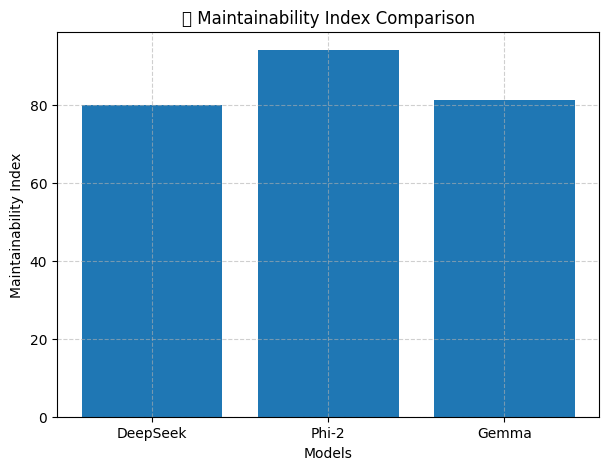

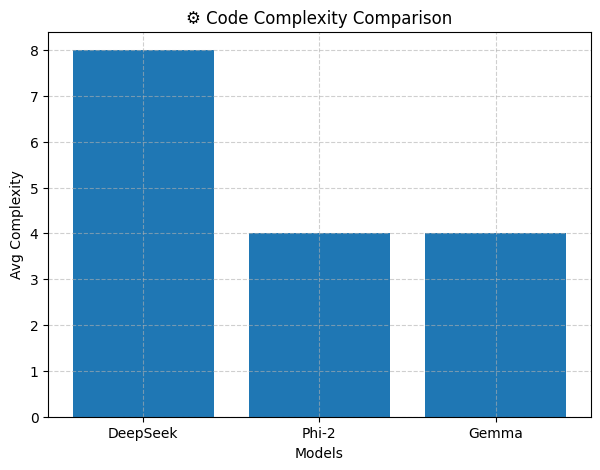

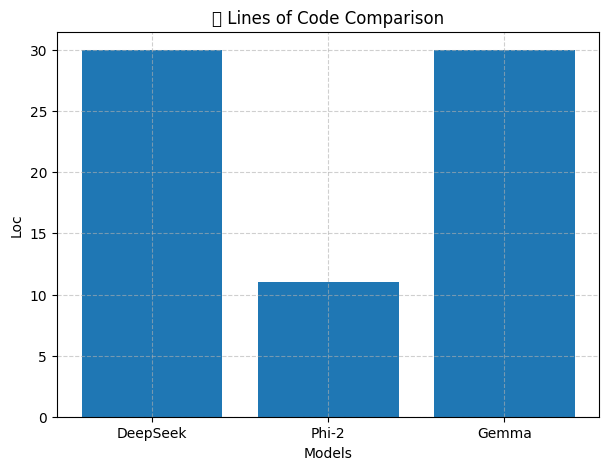

In [ ]:
def visualize_model_performance(df):
    metrics = ["maintainability_index", "avg_complexity", "loc"]
    titles = ["📈 Maintainability Index", "⚙️ Code Complexity", "📏 Lines of Code"]
    for metric, title in zip(metrics, titles):
        plt.figure(figsize=(7,5))
        plt.bar(df.index, df[metric])
        plt.title(title + " Comparison")
        plt.xlabel("Models")
        plt.ylabel(metric.replace("_", " ").title())
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

visualize_model_performance(df)


In [1]:
import json

path = "/content/Milestone2_Notebook.ipynb"  # your notebook filename

with open(path, "r", encoding="utf-8") as f:
    nb = json.load(f)

if "widgets" in nb.get("metadata", {}):
    print("🧹 Removing metadata.widgets section...")
    del nb["metadata"]["widgets"]

# Save cleaned file
clean_path = path.replace(".ipynb", "_CLEAN.ipynb")
with open(clean_path, "w", encoding="utf-8") as f:
    json.dump(nb, f, indent=2)

print(f"✅ Clean notebook saved as: {clean_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/Milestone2_Notebook.ipynb'

In [5]:
import os

print("📂 Files currently in /content/:")
for file in os.listdir("/content"):
    if file.endswith(".ipynb"):
        print("➡️", file)


📂 Files currently in /content/:
